# 1. Creating your own dataset from Google Images

In [2]:
# Importing libraries
import fastai
fastai.__version__


'1.0.59'

In [0]:
from fastai import *
from fastai.vision import *

## 1.1 Get a list of URLs

 **Search and scroll**

Go to Google Images and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

Copy paste this in the browser console (F12) to download the URLs of all the searched Google images.

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```


### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.


In [0]:


path = Path('data/imgcls')

In [0]:
def create_folder():
  path = Path('data/imgcls')
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)


In [0]:
folder = 'book'
file = '/content/data/imgcls/book/book.txt'
create_folder()

In [0]:
folder = 'guitar'
file = '/content/data/imgcls/guitar/guitar.txt'
create_folder()

In [0]:
folder = 'earphones'
file = '/content/data/imgcls/earphones/earphones.txt'
create_folder()

In [0]:
folder = 'watch'
file = '/content/data/imgcls/watch/watch.txt'
create_folder()

In [10]:
from google.colab import files
book = files.upload()


Saving book.txt to book (1).txt


In [11]:
guitar = files.upload()

Saving guitar.txt to guitar (1).txt


In [12]:
earphones = files.upload()

Saving earphones.txt to earphones (1).txt


In [13]:
watch = files.upload()

Saving watch.txt to watch (1).txt


# Download images

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [0]:
classes = ['book', 'guitar', 'earphones', 'watch'] # define your classes here

In [0]:
download_images('book.txt'  , '/content/data/imgcls/book/', max_pics=400)

In [0]:
download_images('earphones.txt'  , '/content/data/imgcls/earphones/', max_pics=400)

In [0]:
download_images('guitar.txt'  , '/content/data/imgcls/guitar/', max_pics=400)

In [0]:
download_images('watch.txt'  , '/content/data/imgcls/watch/', max_pics=400)

Then we can remove any images that can't be opened:

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)


## View data

In [0]:


np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)



In [0]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [21]:
data.classes

['book', 'earphones', 'guitar', 'watch']

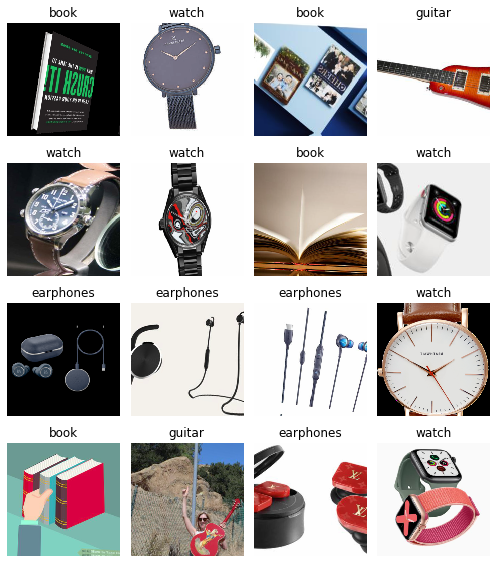

In [22]:
data.show_batch(rows=4, figsize=(7,8))

In [23]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['book', 'earphones', 'guitar', 'watch'], 4, 1188, 296)

# Train model

In [0]:


learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [25]:


learn.fit_one_cycle(4)



epoch,train_loss,valid_loss,error_rate,time
0,0.883682,0.018343,0.006757,00:20
1,0.408403,0.008445,0.003378,00:20
2,0.242074,0.029787,0.010135,00:20
3,0.172062,0.029067,0.006757,00:20


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [29]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.085306,0.047084,0.016892,00:20
1,0.058042,0.031221,0.006757,00:20


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

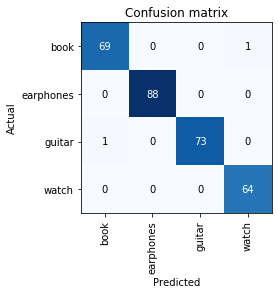

In [33]:
interp.plot_confusion_matrix()

In [37]:
interp.most_confused()

[('book', 'watch', 1), ('guitar', 'book', 1)]

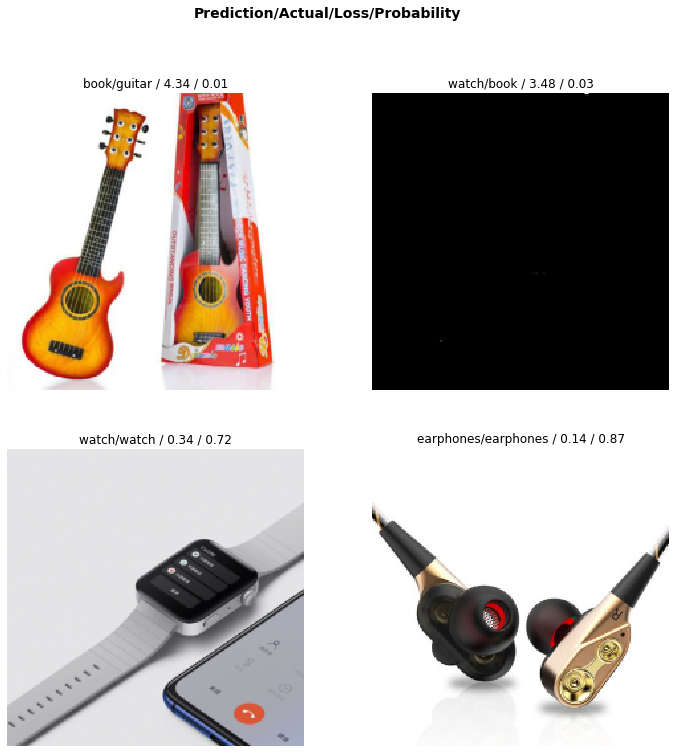

In [38]:
interp.plot_top_losses(4)

# Cleaning Noisy Images


In [0]:
from fastai.widgets import ImageCleaner, DatasetFormatter
from fastai import *

In [0]:
losses, idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [0]:
top_loss_paths

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [42]:
db

ImageDataBunch;

Train: LabelList (1484 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
book,book,book,book,book
Path: data/imgcls;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/imgcls;

Test: None

In [51]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

In [0]:
# Jupyter Widgets (ipywidgets) does not work on Colab - try local jupyter notebook!
# ImageCleaner(ds, idxs, path)

In [0]:
df = pd.read_csv(path/'cleaned.csv', header='infer')

## Deploying to Production

In [47]:
data.classes

['book', 'earphones', 'guitar', 'watch']

For inference we can use CPU

In [48]:
path

PosixPath('data/imgcls')

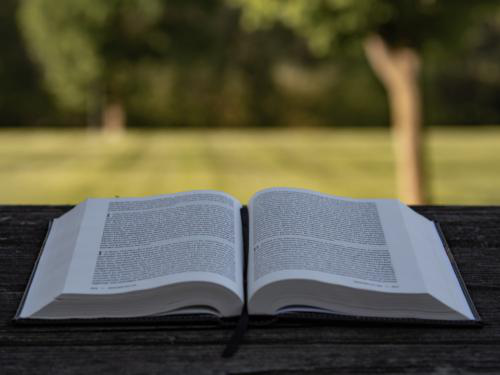

In [49]:
img = open_image(path/'book'/'00000014.jpg')
img

In [54]:
# Prepare ImageDataBunch with the same transformations - ideally run this once
# when the app loads
classes = ['book', 'earphones', 'guitar', 'watch']
data1 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(),
                                           size=224).normalize(imagenet_stats)
learn1 = cnn_learner(data1, models.resnet34)
learn1.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/imgcls;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/imgcls;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): 

In [55]:
pred_class, pred_idx, outputs = learn1.predict(img)
pred_class

Category book

## Export Model

In [0]:
learn1.export()

This exported trained model can now be served in the backend for inference on the web.